# code runs!<br>
do final clean and add ROC

In [164]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from tqdm import tqdm

import json
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn import tree

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive') 
# path = '/content/gdrive/MyDrive/IFT 6390/kaggle2/'

In [4]:
tqdm.pandas()

### read and prep data

In [9]:
# input_path = path+'data/input/'
input_path = 'data/input/'

In [10]:
all_train_data = pd.read_csv(input_path + 'train_data_prepped.csv').fillna('')
all_test_data = pd.read_csv(input_path + 'test_data_prepped.csv').fillna('')

In [11]:
train_target = pd.read_csv(input_path + 'train_results.csv')
train_target['target'].value_counts()

positive    520436
negative    519803
neutral         84
Name: target, dtype: int64

In [12]:
train_target['target'] = [0 if t == 'negative' else 2 if t == 'positive' else 2 for t in train_target['target'].values]

In [13]:
all_train_data['target'] = train_target['target']

In [14]:
all_train_data['target'].value_counts()

2    520520
0    519803
Name: target, dtype: int64

### estblish parameters

In [11]:
vocab_sizes = [100, 1_000, 10_000]
ngrams = [(1, 1), (2, 2), (1, 2), (1, 3)]
text_columns = ['text_no_numerals', 'text_no_sw', 'text_porter_stemmed', 'text_lancaster_stemmed', 'text_lemmatized']
vectorizers = [TfidfVectorizer, CountVectorizer]
models = [DecisionTreeClassifier()]


set decision tree parameters

In [12]:
param_grid = {
    'criterion': ['gini',],
    'max_depth': [5, 10, 30],
    'max_features': ['sqrt', 'log2', None],
    
}

In [13]:
def trainModels(train_data, targets, vocab_sizes, text_columns, ngrams, vectorizers, models, param_grid):
    param_tracker = []
    predictions_tracker = []
    counter = 1
    for size in tqdm(vocab_sizes):


        for col in text_columns:

            text = train_data[col]
            for ng in ngrams:

                for vectorizer in vectorizers:
                  
                    vectorizer = vectorizer(max_features=size, ngram_range=ng)
                    BOW = vectorizer.fit_transform(text)
                    BOW_array = BOW.toarray()
                    print('BOW shape: ', BOW_array.shape)

                    X_train, X_valid, y_train, y_valid = train_test_split(BOW_array, targets, test_size=0.2, random_state=42)


                    for model in models:
                        vectorizer_name = str(vectorizer).split('.')[-1].replace('>', '').replace("\'",'').strip()
                        model_name = str(model)
                        counter+=1
                        if counter % 10==0:
                            print(f'{counter}')

                        grid = RandomizedSearchCV(estimator = model,
                                         param_distributions=param_grid,
                                         scoring = 'accuracy',
                                         cv=3,
                                         n_iter=5,
                                         verbose=0)

                        grid.fit(X_train, y_train)

                        accuracy = grid.score(X_valid, y_valid)

                        grid_params = grid.best_params_
                        criterion = grid_params['criterion']
                        max_depth = grid_params['max_depth']
                        max_features = grid_params['max_features']
                        print('accuracy: ', accuracy, '\n')

                        model_params = {

                            'vocab_size': size,
                            'model_name': model_name,
                            'text_column': col,
                            'ngram': ng,
                            'vectorizer': vectorizer_name,
                            'splitting_criterion': criterion,
                            'tree_max_depth': max_depth,
                            'tree_max_features': max_features,
                            'accuracy': accuracy


                        }


                        param_tracker.append(model_params)


            

    return param_tracker



In [13]:
sample_size=5000
v1_data = all_train_data.sample(sample_size)
v1_train_X = v1_data.iloc[:, :-1]
v1_train_y  = v1_data.iloc[:, -1]

In [14]:
param_tracker = trainModels(v1_train_X, v1_train_y, vocab_sizes, text_columns, ngrams, vectorizers, models, param_grid)

  0%|          | 0/3 [00:00<?, ?it/s]

BOW shape:  (5000, 100)
accuracy:  0.605 

BOW shape:  (5000, 100)
accuracy:  0.639 

BOW shape:  (5000, 100)
accuracy:  0.537 

BOW shape:  (5000, 100)
accuracy:  0.541 

BOW shape:  (5000, 100)
accuracy:  0.6 

BOW shape:  (5000, 100)
accuracy:  0.623 

BOW shape:  (5000, 100)
accuracy:  0.593 

BOW shape:  (5000, 100)
accuracy:  0.604 

BOW shape:  (5000, 100)
10
accuracy:  0.579 

BOW shape:  (5000, 100)
accuracy:  0.595 

BOW shape:  (5000, 100)
accuracy:  0.516 

BOW shape:  (5000, 100)
accuracy:  0.516 

BOW shape:  (5000, 100)
accuracy:  0.606 

BOW shape:  (5000, 100)
accuracy:  0.597 

BOW shape:  (5000, 100)
accuracy:  0.587 

BOW shape:  (5000, 100)
accuracy:  0.586 

BOW shape:  (5000, 100)
accuracy:  0.579 

BOW shape:  (5000, 100)
accuracy:  0.594 

BOW shape:  (5000, 100)
20
accuracy:  0.524 

BOW shape:  (5000, 100)
accuracy:  0.544 

BOW shape:  (5000, 100)
accuracy:  0.592 

BOW shape:  (5000, 100)
accuracy:  0.607 

BOW shape:  (5000, 100)
accuracy:  0.576 

BOW sha

 33%|███▎      | 1/3 [00:18<00:36, 18.29s/it]

accuracy:  0.615 

BOW shape:  (5000, 1000)
accuracy:  0.645 

BOW shape:  (5000, 1000)
accuracy:  0.651 

BOW shape:  (5000, 1000)
accuracy:  0.527 

BOW shape:  (5000, 1000)
accuracy:  0.521 

BOW shape:  (5000, 1000)
accuracy:  0.626 

BOW shape:  (5000, 1000)
accuracy:  0.639 

BOW shape:  (5000, 1000)
accuracy:  0.589 

BOW shape:  (5000, 1000)
accuracy:  0.646 

BOW shape:  (5000, 1000)
50
accuracy:  0.6 

BOW shape:  (5000, 1000)
accuracy:  0.599 

BOW shape:  (5000, 1000)
accuracy:  0.515 

BOW shape:  (5000, 1000)
accuracy:  0.513 

BOW shape:  (5000, 1000)
accuracy:  0.599 

BOW shape:  (5000, 1000)
accuracy:  0.567 

BOW shape:  (5000, 1000)
accuracy:  0.6 

BOW shape:  (5000, 1000)
accuracy:  0.601 

BOW shape:  (5000, 1000)
accuracy:  0.636 

BOW shape:  (5000, 1000)
accuracy:  0.643 

BOW shape:  (5000, 1000)
60
accuracy:  0.505 

BOW shape:  (5000, 1000)
accuracy:  0.51 

BOW shape:  (5000, 1000)
accuracy:  0.59 

BOW shape:  (5000, 1000)
accuracy:  0.642 

BOW shape:  (

 67%|██████▋   | 2/3 [02:32<01:26, 86.37s/it]

accuracy:  0.59 

BOW shape:  (5000, 9106)
accuracy:  0.639 

BOW shape:  (5000, 9106)
accuracy:  0.576 

BOW shape:  (5000, 10000)
accuracy:  0.518 

BOW shape:  (5000, 10000)
accuracy:  0.512 

BOW shape:  (5000, 10000)
accuracy:  0.547 

BOW shape:  (5000, 10000)
accuracy:  0.639 

BOW shape:  (5000, 10000)
accuracy:  0.603 

BOW shape:  (5000, 10000)
accuracy:  0.589 

BOW shape:  (5000, 9020)
90
accuracy:  0.608 

BOW shape:  (5000, 9020)
accuracy:  0.604 

BOW shape:  (5000, 10000)
accuracy:  0.513 

BOW shape:  (5000, 10000)
accuracy:  0.511 

BOW shape:  (5000, 10000)
accuracy:  0.606 

BOW shape:  (5000, 10000)
accuracy:  0.605 

BOW shape:  (5000, 10000)
accuracy:  0.583 

BOW shape:  (5000, 10000)
accuracy:  0.604 

BOW shape:  (5000, 7878)
accuracy:  0.644 

BOW shape:  (5000, 7878)
accuracy:  0.655 

BOW shape:  (5000, 10000)
100
accuracy:  0.526 

BOW shape:  (5000, 10000)
accuracy:  0.52 

BOW shape:  (5000, 10000)
accuracy:  0.66 

BOW shape:  (5000, 10000)
accuracy:  0

100%|██████████| 3/3 [18:19<00:00, 366.63s/it]

accuracy:  0.649 



In [15]:
param_df = pd.DataFrame(param_tracker,)
param_df = param_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True)


In [16]:
param_df.iloc[0]['vectorizer'].split('.')[-1].replace('>', '').replace("\'",'').strip()

'TfidfVectorizer(max_features=10000, ngram_range=(1, 2))'

saving and loading results

In [17]:
param_df.to_csv(path+'data/output/decision_tree/decision_tree_params.csv', index=False)


In [18]:
param_df = pd.read_csv(path+'data/output/decision_tree_params.csv')
param_df['ngram'] = [(int(ng[1]), int(ng[4])) for ng in param_df['ngram'].values]
param_df = param_df.replace({np.nan: None})
param_df.head(3)


,vocab_size,model_name,text_column,ngram,vectorizer,splitting_criterion,tree_max_depth,tree_max_features,accuracy
0,1000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 2)",CountVectorizer,gini,30,None,0.644
1,10000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 2)",CountVectorizer,gini,30,None,0.644
2,10000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 1)",CountVectorizer,gini,30,None,0.640


get best 20 combinations and train on more data

In [21]:
top_20_params = param_df[:20]

# for cross validation, num folds   
k = 3

In [22]:
sample_size=20_000
v2_data = all_train_data.sample(sample_size).reset_index(drop=True)
v2_train_X = v2_data.iloc[:, :-1]
v2_train_y  = v2_data.iloc[:, -1]

In [23]:

model_accuracy = []
predictions = []
for i, param_set in enumerate(tqdm(top_20_params.values)):
    (vocab_size, 
     model_type, 
     text_column, 
     ngram, 
     vectorizer, 
     criterion, 
     max_depth,
     max_features, 
     *_) = param_set
    

    
    print(vocab_size, model_type, text_column, ngram, vectorizer, criterion, max_depth, max_features)
    
    if vocab_size:
        vocab_size = int(vocab_size)
        
        
    if vectorizer == 'TfidfVectorizer':
        vectorizer = TfidfVectorizer
    elif vectorizer == 'CountVectorizer':
        vectorizer = CountVectorizer

    else:
        print('warning, unrecognized vectorizer!')
        print(i, param_set)
    
    print('vectorizing')
    model_vectorizer = vectorizer(max_features=vocab_size, ngram_range=ngram)

    print('creating BOW')
    
    BOW = model_vectorizer.fit_transform(v2_train_X[text_column])
    BOW_array = BOW.toarray()
    
    
    kfolds = KFold(n_splits=k)
    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features)
    
    acc_score = []
    for train_index , valid_index in kfolds.split(BOW_array):
        X_train , X_test = BOW_array[train_index,:],BOW_array[valid_index,:]
        y_train , y_test = v2_train_y[train_index] , v2_train_y[valid_index]
        
        print('fitting fold')
        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)

        acc = accuracy_score(pred_values , y_test)
        print('fold acc: ', acc)
        acc_score.append(acc)
        
        pred_probs = model.predict_proba(X_test)

    mean_acc = sum(acc_score)/len(acc_score)
    
    print(mean_acc, '\n\n')
    model_accuracy.append(mean_acc)
    predictions.append(pred_probs)
    


  0%|          | 0/20 [00:00<?, ?it/s]

1000 DecisionTreeClassifier() text_porter_stemmed (1, 2) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6553172341382931
fitting fold
fold acc:  0.6683665816709164
fitting fold


  5%|▌         | 1/20 [00:14<04:40, 14.74s/it]

fold acc:  0.6678667866786678
0.6638502008292925 


10000 DecisionTreeClassifier() text_porter_stemmed (1, 2) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6626668666566672
fitting fold
fold acc:  0.6764661766911655
fitting fold


 10%|█         | 2/20 [01:55<19:33, 65.18s/it]

fold acc:  0.6773177317731773
0.6721502583736699 


10000 DecisionTreeClassifier() text_porter_stemmed (1, 1) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.656217189140543
fitting fold
fold acc:  0.6739163041847908
fitting fold


 15%|█▌        | 3/20 [04:47<32:18, 114.03s/it]

fold acc:  0.6672667266726673
0.665800073332667 


1000 DecisionTreeClassifier() text_porter_stemmed (1, 1) TfidfVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6449677516124194
fitting fold
fold acc:  0.6587670616469177
fitting fold


 20%|██        | 4/20 [05:04<20:10, 75.63s/it] 

fold acc:  0.6573657365736574
0.6537001832776649 


10000 DecisionTreeClassifier() text_lancaster_stemmed (1, 2) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6619169041547922
fitting fold
fold acc:  0.6740662966851657
fitting fold


 25%|██▌       | 5/20 [06:39<20:42, 82.81s/it]

fold acc:  0.6728172817281728
0.6696001608560436 


10000 DecisionTreeClassifier() text_lancaster_stemmed (1, 1) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6596670166491675
fitting fold
fold acc:  0.6769161541922903
fitting fold


 30%|███       | 6/20 [08:48<22:59, 98.56s/it]

fold acc:  0.6695169516951696
0.6687000408455425 


1000 DecisionTreeClassifier() text_porter_stemmed (1, 1) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6532173391330434
fitting fold
fold acc:  0.6698665066746663
fitting fold


 35%|███▌      | 7/20 [09:04<15:26, 71.30s/it]

fold acc:  0.6686168616861686
0.6639002358312928 


10000 DecisionTreeClassifier() text_lancaster_stemmed (1, 3) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6599670016499175
fitting fold
fold acc:  0.6790160491975401
fitting fold


 40%|████      | 8/20 [10:48<16:21, 81.80s/it]

fold acc:  0.6770177017701771
0.672000250872545 


10000 DecisionTreeClassifier() text_lancaster_stemmed (1, 1) TfidfVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6517174141292935
fitting fold
fold acc:  0.6685165741712914
fitting fold


 45%|████▌     | 9/20 [12:58<17:47, 97.00s/it]

fold acc:  0.6660666066606661
0.662100198320417 


1000 DecisionTreeClassifier() text_lancaster_stemmed (1, 2) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6580170991450427
fitting fold
fold acc:  0.672266386680666
fitting fold


 50%|█████     | 10/20 [13:14<11:57, 71.77s/it]

fold acc:  0.6705670567056705
0.6669501808437931 


100 DecisionTreeClassifier() text_porter_stemmed (1, 1) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.623818809059547
fitting fold
fold acc:  0.6191690415479226


 55%|█████▌    | 11/20 [13:14<07:30, 50.10s/it]

fitting fold
fold acc:  0.6167116711671167
0.6198998405915287 


10000 DecisionTreeClassifier() text_porter_stemmed (1, 1) TfidfVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6581670916454178
fitting fold
fold acc:  0.664016799160042
fitting fold


 60%|██████    | 12/20 [15:07<09:11, 68.98s/it]

fold acc:  0.6518151815181518
0.6579996907745372 


10000 DecisionTreeClassifier() text_lemmatized (1, 3) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6551672416379181
fitting fold
fold acc:  0.6688165591720414
fitting fold


 65%|██████▌   | 13/20 [18:23<12:33, 107.71s/it]

fold acc:  0.666966696669667
0.6636501658265421 


1000 DecisionTreeClassifier() text_no_numerals (1, 1) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6526173691315434
fitting fold
fold acc:  0.6541172941352932
fitting fold


 70%|███████   | 14/20 [18:40<08:00, 80.14s/it] 

fold acc:  0.6531653165316532
0.6532999932661633 


1000 DecisionTreeClassifier() text_no_numerals (1, 2) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6466176691165442
fitting fold
fold acc:  0.6581670916454178
fitting fold


 75%|███████▌  | 15/20 [18:55<05:03, 60.66s/it]

fold acc:  0.6548154815481548
0.653200080770039 


1000 DecisionTreeClassifier() text_lemmatized (1, 3) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6505174741262937
fitting fold
fold acc:  0.6658167091645417
fitting fold


 80%|████████  | 16/20 [19:12<03:09, 47.28s/it]

fold acc:  0.6647164716471647
0.6603502183126667 


100 DecisionTreeClassifier() text_lancaster_stemmed (1, 3) CountVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.623368831558422
fitting fold
fold acc:  0.6191690415479226
fitting fold


 85%|████████▌ | 17/20 [19:16<01:42, 34.25s/it]

fold acc:  0.624062406240624
0.6222000931156563 


1000 DecisionTreeClassifier() text_lemmatized (1, 3) TfidfVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6469176541172942
fitting fold
fold acc:  0.655917204139793
fitting fold


 90%|█████████ | 18/20 [19:33<00:58, 29.23s/it]

fold acc:  0.6534653465346535
0.6521000682639135 


10000 DecisionTreeClassifier() text_porter_stemmed (1, 2) TfidfVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6521673916304185
fitting fold
fold acc:  0.6608669566521674
fitting fold


 95%|█████████▌| 19/20 [21:53<01:02, 62.51s/it]

fold acc:  0.6629162916291629
0.6586502133039163 


1000 DecisionTreeClassifier() text_lemmatized (1, 2) TfidfVectorizer gini 30 None
vectorizing
creating BOW
fitting fold
fold acc:  0.6460176991150443
fitting fold
fold acc:  0.6598170091495426
fitting fold


100%|██████████| 20/20 [22:11<00:00, 66.57s/it]

fold acc:  0.6512151215121512
0.6523499432589127 




In [24]:
model_accuracy

[0.6638502008292925,
 0.6721502583736699,
 0.665800073332667,
 0.6537001832776649,
 0.6696001608560436,
 0.6687000408455425,
 0.6639002358312928,
 0.672000250872545,
 0.662100198320417,
 0.6669501808437931,
 0.6198998405915287,
 0.6579996907745372,
 0.6636501658265421,
 0.6532999932661633,
 0.653200080770039,
 0.6603502183126667,
 0.6222000931156563,
 0.6521000682639135,
 0.6586502133039163,
 0.6523499432589127]

In [25]:
top_20_params['acc2'] = model_accuracy
top_20_params = top_20_params.sort_values(by='acc2', ascending=False).reset_index(drop=True)
top_20_params

<ipython-input-25-beeda0af3506>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_params['acc2'] = model_accuracy


,vocab_size,model_name,text_column,ngram,vectorizer,splitting_criterion,tree_max_depth,tree_max_features,accuracy,acc2
0,10000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 2)",CountVectorizer,gini,30,None,0.644,0.67215
1,10000,DecisionTreeClassifier(),text_lancaster_stemmed,"(1, 3)",CountVectorizer,gini,30,None,0.634,0.67200
2,10000,DecisionTreeClassifier(),text_lancaster_stemmed,"(1, 2)",CountVectorizer,gini,30,None,0.638,0.66960
3,10000,DecisionTreeClassifier(),text_lancaster_stemmed,"(1, 1)",CountVectorizer,gini,30,None,0.637,0.66870
4,1000,DecisionTreeClassifier(),text_lancaster_stemmed,"(1, 2)",CountVectorizer,gini,30,None,0.632,0.66695
5,10000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 1)",CountVectorizer,gini,30,None,0.640,0.66580
6,1000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 1)",CountVectorizer,gini,30,None,0.635,0.66390
7,1000,DecisionTreeClassifier(),text_porter_stemmed,"(1, 2)",CountVectorizer,gini,30,None,0.644,0.66385
8,10000,DecisionTreeClassifier(),text_lemmatized,"(1, 3)",CountVectorizer,gini,30,None,0.628,0.66365
9,10000,DecisionTreeClassifier(),text_lancaster_stemmed,"(1, 1)",TfidfVectorizer,gini,30,None,0.633,0.66210


save and load results

In [26]:
top_20_params.to_csv(path+'data/output/decision_tree/decision_tree_top_20_params.csv', index=False)

In [15]:
top_20_params = pd.read_csv(path+'data/output/decision_tree_top_20_params.csv')
top_20_params['ngram'] = [(int(ng[1]), int(ng[4])) for ng in top_20_params['ngram'].values]
top_20_params = top_20_params.replace({np.nan: None})
top_20_params.head(3)

,vocab_size,model_name,text_column,ngram,vectorizer,splitting_criterion,tree_max_depth,tree_max_features,accuracy,acc2
0,1000,DecisionTreeClassifier(),text_no_numerals,"(1, 1)",CountVectorizer,gini,30,None,0.628,0.6621
1,1000,DecisionTreeClassifier(),text_no_numerals,"(1, 2)",CountVectorizer,gini,30,None,0.628,0.6615
2,10000,DecisionTreeClassifier(),text_lancaster_stemmed,"(1, 1)",CountVectorizer,gini,30,None,0.637,0.65575


repeat tuning one last time with top 3 parameter combos and more data

In [16]:
top_3_params = top_20_params[:3]

In [17]:
sample_size=100_000
k=3
v3_data = all_train_data.sample(sample_size).reset_index(drop=True)
v3_train_X = v3_data.iloc[:, :-1]
v3_train_y  = v3_data.iloc[:, -1]

In [18]:

model_accuracy = []
top_3_predictions = []
for i, param_set in enumerate(tqdm(top_3_params.values)):
    (vocab_size, 
     model_type, 
     text_column, 
     ngram, 
     vectorizer, 
     criterion, 
     max_depth,
     max_features, 
     *_) = param_set
    

    
    print(vocab_size, model_type, text_column, ngram, vectorizer, criterion, max_depth, max_features)
    
    if vocab_size:
        vocab_size = int(vocab_size)
        
        
    if vectorizer == 'TfidfVectorizer':
        vectorizer = TfidfVectorizer
    elif vectorizer == 'CountVectorizer':
        vectorizer = CountVectorizer

    else:
        print('warning, unrecognized vectorizer!')
        print(i, param_set)
    
    print('vectorizing')
    model_vectorizer = vectorizer(max_features=vocab_size, ngram_range=ngram)

    print('creating BOW')
    
    BOW = model_vectorizer.fit_transform(v3_train_X[text_column])
    BOW_array = BOW
    print('splitting train-validation data')
    


    

    kfolds = KFold(n_splits=k)
    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features)
    
    acc_score = []
    for train_index , valid_index in kfolds.split(BOW_array):
        X_train , X_test = BOW_array[train_index,:],BOW_array[valid_index,:]
        y_train , y_test = v3_train_y[train_index] , v3_train_y[valid_index]
        
        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)

        acc = accuracy_score(pred_values , y_test)
        acc_score.append(acc)
        
        pred_probs = model.predict_proba(X_test)

    mean_acc = sum(acc_score)/len(acc_score)
    # mean_probs = 
    
    print(mean_acc, '\n\n')
    model_accuracy.append(mean_acc)
    top_3_predictions.append(pred_probs)
    


  0%|          | 0/3 [00:00<?, ?it/s]

1000 DecisionTreeClassifier() text_no_numerals (1, 1) CountVectorizer gini 30 None
vectorizing
creating BOW
splitting train-validation data


 33%|███▎      | 1/3 [00:16<00:33, 16.64s/it]

0.6724600161343307 


1000 DecisionTreeClassifier() text_no_numerals (1, 2) CountVectorizer gini 30 None
vectorizing
creating BOW
splitting train-validation data


 67%|██████▋   | 2/3 [00:34<00:17, 17.23s/it]

0.6722700238342156 


10000 DecisionTreeClassifier() text_lancaster_stemmed (1, 1) CountVectorizer gini 30 None
vectorizing
creating BOW
splitting train-validation data


100%|██████████| 3/3 [00:51<00:00, 17.21s/it]

0.6842099956368856 




In [19]:
top_3_params['acc3'] = model_accuracy
top_3_params = top_3_params.sort_values(by='acc3', ascending=False).reset_index(drop=True)
top_3_params

<ipython-input-19-1f294fd60d34>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_params['acc3'] = model_accuracy


,vocab_size,model_name,text_column,ngram,vectorizer,splitting_criterion,tree_max_depth,tree_max_features,accuracy,acc2,acc3
0,10000,DecisionTreeClassifier(),text_lancaster_stemmed,"(1, 1)",CountVectorizer,gini,30,None,0.637,0.65575,0.68421
1,1000,DecisionTreeClassifier(),text_no_numerals,"(1, 1)",CountVectorizer,gini,30,None,0.628,0.6621,0.67246
2,1000,DecisionTreeClassifier(),text_no_numerals,"(1, 2)",CountVectorizer,gini,30,None,0.628,0.6615,0.67227


In [20]:
top_3_params.to_csv(path+'data/output/decision_tree/decision_tree_top_3_params.csv', index=False)

### train final model on best params

In [195]:

vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 1))


BOW = vectorizer.fit_transform(all_train_data['text_lancaster_stemmed'])




the validation data will be used to generate the ROC curve

In [196]:
X_train, X_valid, y_train, y_valid = train_test_split(BOW, all_train_data['target'], test_size=0.2, random_state=42)


In [197]:
model = DecisionTreeClassifier(criterion='gini', max_depth=30, max_features=None)

In [198]:
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=30)

transform test data

In [199]:
test_BOW = vectorizer.transform(all_test_data['text_lancaster_stemmed'])


In [200]:
prediction_values = model.predict(test_BOW)


In [201]:
prediction_probs = model.predict_proba(test_BOW)

In [202]:
pos_predictions = [pred[-1] for pred in prediction_probs]

In [203]:
thresh = 0.5

In [204]:
bin_pred = []
for pred in pos_predictions:
    if pred >= thresh:
        binary_pred = 2
    else:
        binary_pred = 0
    bin_pred.append(binary_pred)

In [205]:
pdf = pd.DataFrame(bin_pred).reset_index()
pdf.columns = ['id', 'target']

In [206]:
pdf['target'].value_counts()

2    325551
0    234624
Name: target, dtype: int64

In [207]:
pdf.to_csv('data/output/decision_tree/decision_tree_predictions.csv', index=False)

### generate ROC curve

In [208]:
valid_predictions = model.predict_proba(X_valid)

In [209]:
model.classes_

array([0, 2])

In [210]:
valid_predictions = [p[1] for p in valid_predictions]

In [211]:
fpr, tpr, thresholds = roc_curve(y_valid, valid_predictions, pos_label=2)

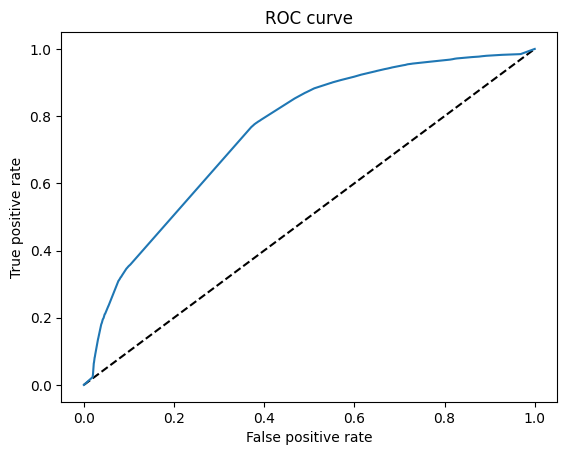

In [212]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig('data/output/decision_tree/ROC.png')
plt.show()

## visualizing model decisions

In [213]:
text_representation = tree.export_text(model)

In [214]:
# fig = plt.figure(figsize=(25,20))
# plt = tree.plot_tree(model, 
#                    feature_names=vectorizer.get_feature_names(),  
# #                    class_names=iris.target_names,
#                    filled=True)

In [215]:
acc = accuracy_score(model.predict(X_valid) , y_valid)
acc

0.6986518636003172

In [216]:
y_valid

672665    2
947427    2
17282     2
838169    0
5028      2
         ..
785651    2
741438    0
816126    2
649280    0
738340    0
Name: target, Length: 208065, dtype: int64

In [217]:
print(text_representation)

|--- feature_8558 <= 0.50
|   |--- feature_7342 <= 0.50
|   |   |--- feature_5484 <= 0.50
|   |   |   |--- feature_9881 <= 0.50
|   |   |   |   |--- feature_5091 <= 0.50
|   |   |   |   |   |--- feature_5941 <= 0.50
|   |   |   |   |   |   |--- feature_3472 <= 0.50
|   |   |   |   |   |   |   |--- feature_5885 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_9620 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_3783 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_9400 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 20
|   |   |   |   |   |   |   |   |   |   |--- feature_9400 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 20
|   |   |   |   |   |   |   |   |   |--- feature_3783 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_5030 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 20
|   |   |   |   |   |   |   |   |   |   |--- feature_5030 >  0.50
